# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni



**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface




# Contact

For any doubt, question, issue or help, you can always contact us at the following email addresses:



Teaching Assistants:



- Federico Ruggeri -> federico.ruggeri6@unibo.it

- Eleonora Mancini -> e.mancini@unibo.it



Professor:

- Paolo Torroni -> p.torroni@unibo.it

# Introduction

You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition

The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).



### Examples:



**Text**: *Can’t go a day without women womening*



**Label**: Sexist



**Text**: *''Society's set norms! Happy men's day though!#weareequal''*



**Label**: Not sexist

In [1]:
!pip install evaluate
!mkdir -p ./data
!wget https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/72c93981fe38020285a16e1558d5d4a314bb1b82/2024-2025/Assignment%201/data/test.json -O data/test.json
!wget https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/72c93981fe38020285a16e1558d5d4a314bb1b82/2024-2025/Assignment%201/data/training.json -O data/training.json
!wget https://raw.githubusercontent.com/nlp-unibo/nlp-course-material/72c93981fe38020285a16e1558d5d4a314bb1b82/2024-2025/Assignment%201/data/validation.json -O data/validation.json

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
--2024-12-18 16:33:10--  https://raw.githubusercontent.com/nlp-unibo/nlp-course-mat

In [2]:
import pandas as pd
import numpy as np
import gensim
import gensim.downloader as gloader
import tensorflow as tf
import re
import string
import nltk
import keras
import gensim
import evaluate
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from functools import reduce
from keras import Input
from keras.layers import Bidirectional, LSTM, Dense, Embedding
from keras.callbacks import Callback, ModelCheckpoint
from keras.optimizers import Nadam
from keras.losses import CategoricalFocalCrossentropy
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag, OrderedDict
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet, stopwords
from sklearn.metrics import f1_score, accuracy_score, precision_recall_curve, ConfusionMatrixDisplay, PrecisionRecallDisplay
from sklearn.utils.class_weight import compute_class_weight
from scipy.special import softmax
from tqdm import tqdm
from tensorflow.keras.utils import Sequence
from transformers import AutoModelForSequenceClassification, TrainingArguments, AutoTokenizer, DataCollatorWithPadding, Trainer

#### Set an initial seed for reproducibility

In [3]:
seed = 42
np.random.seed(seed)

# [Task 1 - 1.0 points] Corpus



We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).



Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.



The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.




### Dataset Description

- The dataset contains tweets in both English and Spanish.

- There are labels for multiple tasks, but we are focusing on **Task 1**.

- For Task 1, soft labels are assigned by six annotators.

- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").












### Example





    "203260": {

        "id_EXIST": "203260",

        "lang": "en",

        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",

        "number_annotators": 6,

        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],

        "gender_annotators": ["F", "F", "M", "M", "M", "F"],

        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],

        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],

        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],

        "labels_task3": [

          ["STEREOTYPING-DOMINANCE"],

          ["OBJECTIFICATION"],

          ["SEXUAL-VIOLENCE"],

          ["-"],

          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],

          ["OBJECTIFICATION"]

        ],

        "split": "TRAIN_EN"

      }

    }

### Instructions

1. **Download** the `A1/data` folder.

2. **Load** the three JSON files and encode them as pandas dataframes.

3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.

4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.

5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.

6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

---

1. **Download** the `A1/data` folder.

2. **Load** the three JSON files and encode them as pandas dataframes.

In [4]:
df_train = pd.read_json("./data/training.json").transpose().set_index("id_EXIST")
df_test = pd.read_json("./data/test.json").transpose().set_index("id_EXIST")
df_val = pd.read_json("./data/validation.json").transpose().set_index("id_EXIST")

In [5]:
df_train.head()

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
id_EXIST,,,,,,,,,,
100001,es,"@TheChiflis Ignora al otro, es un capullo.El p...",6,"[Annotator_1, Annotator_2, Annotator_3, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, YES, NO, YES, YES, YES]","[REPORTED, JUDGEMENTAL, -, REPORTED, JUDGEMENT...","[[OBJECTIFICATION], [OBJECTIFICATION, SEXUAL-V...",TRAIN_ES
100002,es,@ultimonomada_ Si comicsgate se parece en algo...,6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, YES, NO]","[-, -, -, -, DIRECT, -]","[[-], [-], [-], [-], [OBJECTIFICATION], [-]]",TRAIN_ES
100003,es,"@Steven2897 Lee sobre Gamergate, y como eso ha...",6,"[Annotator_7, Annotator_8, Annotator_9, Annota...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",TRAIN_ES
100004,es,@Lunariita7 Un retraso social bastante lamenta...,6,"[Annotator_13, Annotator_14, Annotator_15, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[NO, NO, YES, NO, YES, YES]","[-, -, DIRECT, -, REPORTED, REPORTED]","[[-], [-], [IDEOLOGICAL-INEQUALITY], [-], [IDE...",TRAIN_ES
100005,es,@novadragon21 @icep4ck @TvDannyZ Entonces como...,6,"[Annotator_19, Annotator_20, Annotator_21, Ann...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 46+, 23-45, 18-22]","[YES, NO, YES, NO, YES, YES]","[REPORTED, -, JUDGEMENTAL, -, JUDGEMENTAL, DIR...","[[STEREOTYPING-DOMINANCE, OBJECTIFICATION], [-...",TRAIN_ES


In [6]:
df_test.head()

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
id_EXIST,,,,,,,,,,
400178,en,1st day at the pool on a beautiful Sunday in N...,6,"[Annotator_764, Annotator_765, Annotator_766, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400179,en,“I like your outfit too except when i dress up...,6,"[Annotator_805, Annotator_426, Annotator_806, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, NO]","[JUDGEMENTAL, DIRECT, REPORTED, DIRECT, REPORT...","[[OBJECTIFICATION], [OBJECTIFICATION, MISOGYNY...",DEV_EN
400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_EN
400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,6,"[Annotator_795, Annotator_796, Annotator_797, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, DIRECT, JUDGEMENTAL, DIRECT, DIRECT, DIRECT]","[[-], [IDEOLOGICAL-INEQUALITY, MISOGYNY-NON-SE...",DEV_EN
400182,en,@ultshunnie u gotta say some shit like “i’ll f...,6,"[Annotator_770, Annotator_771, Annotator_772, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, YES, YES, YES, YES]","[DIRECT, REPORTED, DIRECT, DIRECT, JUDGEMENTAL...","[[OBJECTIFICATION, SEXUAL-VIOLENCE], [SEXUAL-V...",DEV_EN


In [7]:
df_val.head()

,lang,tweet,number_annotators,annotators,gender_annotators,age_annotators,labels_task1,labels_task2,labels_task3,split
id_EXIST,,,,,,,,,,
300001,es,@Fichinescu La comunidad gamer es un antro de ...,6,"[Annotator_726, Annotator_727, Annotator_357, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, NO, YES, NO]","[-, JUDGEMENTAL, JUDGEMENTAL, -, REPORTED, -]","[[-], [MISOGYNY-NON-SEXUAL-VIOLENCE], [MISOGYN...",DEV_ES
300002,es,@anacaotica88 @MordorLivin No me acuerdo de lo...,6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[YES, YES, NO, YES, YES, YES]","[JUDGEMENTAL, REPORTED, -, JUDGEMENTAL, JUDGEM...","[[IDEOLOGICAL-INEQUALITY, STEREOTYPING-DOMINAN...",DEV_ES
300003,es,@cosmicJunkBot lo digo cada pocos dias y lo re...,6,"[Annotator_735, Annotator_736, Annotator_345, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, NO, NO, NO, NO, NO]","[-, -, -, -, -, -]","[[-], [-], [-], [-], [-], [-]]",DEV_ES
300004,es,Also mientras les decia eso la señalaba y deci...,6,"[Annotator_259, Annotator_739, Annotator_291, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, YES, YES, YES, YES]","[-, REPORTED, REPORTED, REPORTED, JUDGEMENTAL,...","[[-], [SEXUAL-VIOLENCE], [SEXUAL-VIOLENCE], [S...",DEV_ES
300005,es,"And all people killed, attacked, harassed by ...",6,"[Annotator_731, Annotator_732, Annotator_315, ...","[F, F, F, M, M, M]","[18-22, 23-45, 46+, 18-22, 23-45, 46+]","[NO, YES, NO, NO, NO, NO]","[-, DIRECT, -, -, -, -]","[[-], [STEREOTYPING-DOMINANCE], [-], [-], [-],...",DEV_ES


In [8]:
print("- Training dataset shape:", df_train.shape)
print("- Test dataset shape:", df_test.shape)
print("- Validation dataset shape:", df_val.shape)

- Training dataset shape: (6920, 10)
- Test dataset shape: (312, 10)
- Validation dataset shape: (726, 10)


3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.

In [9]:
df_train_T1 = df_train.copy()
df_test_T1 = df_test.copy()
df_val_T1 = df_val.copy()

# For each row of the datasets, using df.apply(), this sets the values for the new "hard_labels_task1" column.

df_train_T1['hard_labels_task1'] = df_train_T1['labels_task1'].apply(
    lambda x: 'YES' if x.count('YES') > x.count('NO') else ('NO' if x.count('NO') > x.count('YES') else np.NAN)
)

df_test_T1['hard_labels_task1'] = df_test_T1['labels_task1'].apply(
    lambda x: 'YES' if x.count('YES') > x.count('NO') else ('NO' if x.count('NO') > x.count('YES') else np.NAN)
)

df_val_T1['hard_labels_task1'] = df_val_T1['labels_task1'].apply(
    lambda x: 'YES' if x.count('YES') > x.count('NO') else ('NO' if x.count('NO') > x.count('YES') else np.NAN)
)


# Since for those rows without a clear majority vote the "hard_labels_task1" column was set to "NaN",
# this removes all those rows with the "NaN" value using df.dropna().

df_train_T1.dropna(inplace=True)
df_test_T1.dropna(inplace=True)
df_val_T1.dropna(inplace=True)

4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.

In [10]:
df_train_T1 = df_train_T1[df_train_T1["lang"] == "en"]
df_test_T1 = df_test_T1[df_test_T1["lang"] == "en"]
df_val_T1 = df_val_T1[df_val_T1["lang"] == "en"]

5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.

In [11]:
df_train_T1 = df_train_T1.drop(
    ["number_annotators", "annotators","gender_annotators","age_annotators","labels_task1","labels_task2","labels_task3","split"],
    axis=1
)

df_test_T1 = df_test_T1.drop(
    ["number_annotators", "annotators","gender_annotators","age_annotators","labels_task1","labels_task2","labels_task3","split"],
    axis=1
)

df_val_T1 = df_val_T1.drop(
    ["number_annotators", "annotators","gender_annotators","age_annotators","labels_task1","labels_task2","labels_task3","split"],
    axis=1
)

6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [12]:
df_train_T1['hard_labels_task1'] = df_train_T1['hard_labels_task1'].apply(lambda x: 1 if x == 'YES' else 0)
df_test_T1['hard_labels_task1'] = df_test_T1['hard_labels_task1'].apply(lambda x: 1 if x == 'YES' else 0)
df_val_T1['hard_labels_task1'] = df_val_T1['hard_labels_task1'].apply(lambda x: 1 if x == 'YES' else 0)

In [13]:
df_train_T1.head()

,lang,tweet,hard_labels_task1
id_EXIST,,,
200002,en,Writing a uni essay in my local pub with a cof...,1
200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,en,According to a customer I have plenty of time ...,1
200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,en,New to the shelves this week - looking forward...,0


In [14]:
df_test_T1.head()

,lang,tweet,hard_labels_task1
id_EXIST,,,
400178,en,1st day at the pool on a beautiful Sunday in N...,0
400179,en,“I like your outfit too except when i dress up...,1
400180,en,"@KNasFanFic 🥺💖 same, though!!! the angst just ...",0
400181,en,@themaxburns @GOP Fuck that cunt. Tried to vot...,1
400182,en,@ultshunnie u gotta say some shit like “i’ll f...,1


In [15]:
df_val_T1.head()

,lang,tweet,hard_labels_task1
id_EXIST,,,
400001,en,"@Mike_Fabricant “You should smile more, love. ...",0
400002,en,@BBCWomansHour @LabWomenDec @EverydaySexism Sh...,1
400003,en,#everydaysexism Some man moving my suitcase in...,1
400004,en,@KolHue @OliverJia1014 lol gamergate the go to...,0
400005,en,@ShelfStoriesGBL To me this has the same negat...,0


In [16]:
print("- Training dataset shape:", df_train_T1.shape)
print("- Test dataset shape:", df_test_T1.shape)
print("- Validation dataset shape:", df_val_T1.shape)

- Training dataset shape: (2870, 3)
- Test dataset shape: (286, 3)
- Validation dataset shape: (158, 3)


# [Task2 - 0.5 points] Data Cleaning

In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.




### Instructions

- **Remove emojis** from the tweets.

- **Remove hashtags** (e.g., `#example`).

- **Remove mentions** such as `@user`.

- **Remove URLs** from the tweets.

- **Remove special characters and symbols**.

- **Remove specific quote characters** (e.g., curly quotes).

- **Perform lemmatization** to reduce words to their base form.

---

In [17]:
nltk.download('punkt_tab')
nltk.download('punkt')
nltk.download('omw-1.4')
nltk.download('wordnet')
#nltk.download('wordnet2022')
nltk.download('averaged_perceptron_tagger')
nltk.download('averaged_perceptron_tagger_eng')

#! cp -rf /usr/share/nltk_data/corpora/wordnet2022 /usr/share/nltk_data/corpora/wordnet

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [18]:
lemmatizer = WordNetLemmatizer()

# This attempts to import a set of English stopwords
try:
    STOPWORDS = set(stopwords.words('english'))

# If the stopwords resource is not found, it is dowloaded.
except LookupError:
    nltk.download('stopwords')
    STOPWORDS = set(stopwords.words('english'))



# This function maps POS tags to WordNet POS tag
# This is needed for using the WordNetLemmatizer()

def get_wordnet_key(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ

    elif pos_tag.startswith('V'):
        return wordnet.VERB

    elif pos_tag.startswith('N'):
        return wordnet.NOUN

    elif pos_tag.startswith('R'):
        return wordnet.ADV

    else:
        return wordnet.NOUN  # default value "noun"



# This function lemmatizes text using WordNet POS tagging

def lem_text(text: str):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    words = [lemmatizer.lemmatize(token, get_wordnet_key(tag)) for token, tag in tagged]
    return " ".join(words)



# To remove emojis

def strip_emoji(text):
    RE_EMOJI = re.compile(u'([\U00002600-\U000027BF])|([\U0001f300-\U0001f64F])|([\U0001f680-\U0001f6FF])')
    return RE_EMOJI.sub(r'', text)



# To remove mentions, hashtags and punctuations.

def strip_tags(text):
    entity_prefixes = ['@','#']
    words = []
    for word in text.split():
        word = word.strip()
        if word:
            if word[0] not in entity_prefixes:
                if entity_prefixes[0] in word:
                    idx = word.find(entity_prefixes[0])
                    words.append(word[:idx])
                elif entity_prefixes[1] in word:
                    idx = word.find(entity_prefixes[1])
                    words.append(word[:idx])
                else:
                    words.append(word)
    return ' '.join(words)



# To remove all links (URLs)

def remove_links(text):
    # Regular expression pattern to match URLs
    url_pattern = r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(url_pattern, '', text)



# To remove special characters and symbols

def special_ch_sym(text):
    RE_ch_sym = re.compile(u'[^a-z A-Z 0-9]')
    return RE_ch_sym.sub(r' ',text)



# To remove "br" characters

def replace_br(text: str) -> str:
    return text.replace('br', '')



# To remove stopwords

def remove_stopwords(text: str) -> str:
    return ' '.join([x for x in text.split() if x and x not in STOPWORDS])



# All the functions are then applied to the text

def text_cleaning(text):

    return lem_text(remove_stopwords(replace_br(special_ch_sym(strip_tags(remove_links(strip_emoji(text.lower().strip())))))))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [19]:
# df_train_T1 -> It contains the origial tweets
# df_train_T2 -> It contains the tweets cleaned version

df_train_T2 = df_train_T1.copy()
df_train_T2['tweet'] = df_train_T2['tweet'].apply(text_cleaning)

df_test_T2 = df_test_T1.copy()
df_test_T2['tweet'] = df_test_T2['tweet'].apply(text_cleaning)

df_val_T2 = df_val_T1.copy()
df_val_T2['tweet'] = df_val_T2['tweet'].apply(text_cleaning)

df_train_T2.head()

,lang,tweet,hard_labels_task1
id_EXIST,,,
200002,en,write uni essay local pub coffee random old ma...,1
200003,en,2021 1921 dont appreciate two ride team member...,1
200006,en,accord customer plenty time go spent stirling ...,1
200007,en,bloke drink beer sorry bloke drink wine appare...,1
200008,en,new shelf week look forward read book,0


In [20]:
print("- Training dataset shape:", df_train_T2.shape)
print("- Test dataset shape:", df_test_T2.shape)
print("- Validation dataset shape:", df_val_T2.shape)

- Training dataset shape: (2870, 3)
- Test dataset shape: (286, 3)
- Validation dataset shape: (158, 3)


# [Task 3 - 0.5 points] Text Encoding

To train a neural sexism classifier, you first need to encode text into numerical format.






### Instructions



* Embed words using **GloVe embeddings**.

* You are **free** to pick any embedding dimension.








### Note : What about OOV tokens?

   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.

   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.

   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)




### More about OOV



For a given token:



* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).

* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.



Your vocabulary **should**:



* Contain all tokens in train set; or

* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

---

1. **Building a vocabulary**

In [21]:
def build_vocabulary(df):
    idx_to_word = OrderedDict()
    word_to_idx = OrderedDict()
    curr_idx = 0

    # "<pad>" it the first element of the dictionary
    word_to_idx['<pad>'] = curr_idx
    idx_to_word[curr_idx] = '<pad>'
    curr_idx += 1

    for sentence in tqdm(df.tweet.values):
        tokens = word_tokenize(sentence)
        for token in tokens:
            if token not in word_to_idx:
                word_to_idx[token] = curr_idx
                idx_to_word[curr_idx] = token
                curr_idx += 1

    # "<unk>" it the last element of the dictionary
    word_to_idx['<unk>'] = curr_idx
    idx_to_word[curr_idx] = '<unk>'

    word_listing = list(idx_to_word.values())

    return idx_to_word, word_to_idx, word_listing

In [22]:
# Vocabulary creation
idx_to_word, word_to_idx, word_listing = build_vocabulary(df_train_T2)

print('\n')
print(f'Index -> Word vocabulary size: {len(idx_to_word)}')
print(f'Word -> Index vocabulary size: {len(word_to_idx)}')
print(f'Some words: {[(idx_to_word[idx], idx) for idx in np.arange(0, 10)]}')

100%|██████████| 2870/2870 [00:06<00:00, 463.58it/s]



Index -> Word vocabulary size: 8999
Word -> Index vocabulary size: 8999
Some words: [('<pad>', 0), ('write', 1), ('uni', 2), ('essay', 3), ('local', 4), ('pub', 5), ('coffee', 6), ('random', 7), ('old', 8), ('man', 9)]


In [23]:
def evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df, check_default_size: bool = False):

    print("  [Vocabulary Evaluation] Size checking...")
    assert len(idx_to_word) == len(word_to_idx)
    assert len(idx_to_word) == len(word_listing)

    print("  [Vocabulary Evaluation] Content checking...")
    for i in tqdm(range(0, len(idx_to_word))):
        assert idx_to_word[i] in word_to_idx
        assert word_to_idx[idx_to_word[i]] == i

    print("  [Vocabulary Evaluation] Consistency checking...")
    _, _, first_word_listing = build_vocabulary(df)
    _, _, second_word_listing = build_vocabulary(df)
    assert first_word_listing == second_word_listing

In [24]:
print("Vocabulary evaluation...")
evaluate_vocabulary(idx_to_word, word_to_idx, word_listing, df_train_T2)
print("\nEvaluation completed!")

Vocabulary evaluation...
  [Vocabulary Evaluation] Size checking...
  [Vocabulary Evaluation] Content checking...


100%|██████████| 8999/8999 [00:00<00:00, 406760.66it/s]


  [Vocabulary Evaluation] Consistency checking...


100%|██████████| 2870/2870 [00:03<00:00, 760.45it/s]



Evaluation completed!


2. **Embedding**

In [25]:
def load_embedding_model(model_type: str, embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:

    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"
    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")

    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [26]:
embedding_dimension = 100 # Possible embeddings: 50, 100, 200, 300
embedding_model = load_embedding_model(model_type="glove", embedding_dimension=embedding_dimension)

[==================================================] 100.0% 128.1/128.1MB downloaded


3. **Out of vocabulary (OOV) words**

In [27]:
# This returns a list of all those in the training set that are not in GloVe

def check_OOV_terms(embedding_model: gensim.models.keyedvectors.KeyedVectors, word_listing):

    embedding_vocabulary = set(embedding_model.key_to_index.keys())
    oov = set(word_listing).difference(embedding_vocabulary)

    return list(oov)

In [28]:
oov_terms = check_OOV_terms(embedding_model, word_listing)
oov_percentage = float(len(oov_terms)) * 100 / len(word_listing)

print(f"Total OOV terms: {len(oov_terms)} ({oov_percentage:.2f}%)")

Total OOV terms: 996 (11.07%)


In [29]:
def build_embedding_matrix(embedding_model, embedding_dimension, word_to_idx, vocab_size, oov_terms):

    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):

        # For each word in the training set, an embedding vector is created by GloVe
        try:
            embedding_vector = embedding_model[word]

        # If the word is not present, it must be added
        except (KeyError, TypeError):
            if word == "<unk>":
                # To "<unk>" a vector al all zeros is set
                embedding_vector = np.zeros(embedding_dimension)

            else:
                # To all the other words a random vector is set
                embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [30]:
# Embedding matrix is built from the vocabulary previously defined

embedding_matrix = build_embedding_matrix(embedding_model,
                                          embedding_dimension,
                                          word_to_idx,
                                          len(word_to_idx),
                                          oov_terms)
vocab_size = embedding_matrix.shape[0]

print(f"\nEmbedding matrix shape: {embedding_matrix.shape}")

8999it [00:00, 258198.86it/s]


Embedding matrix shape: (8999, 100)


# [Task 4 - 1.0 points] Model definition



You are now tasked to define your sexism classifier.






### Instructions



* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.

* You are **free** to experiment with hyper-parameters to define the baseline model.



* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping



You can follow two approaches for encoding tokens in your classifier.



### Work directly with embeddings



- Compute the embedding of each input token

- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model



### Work with Embedding layer



- Encode input tokens to token ids

- Define a Embedding layer as the first layer of your model

- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)

- Initialize the Embedding layer with the computed embedding matrix

- You are **free** to set the Embedding layer trainable or not

### Padding



Pay attention to padding tokens!



Your model **should not** be penalized on those tokens.



#### How to?



There are two main ways.



However, their implementation depends on the neural library you are using.



- Embedding layer

- Custom loss to compute average cross-entropy on non-padding tokens only



**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

---

In [31]:
# ----- Hyperparameters ----- #

hidden_dim = 64
num_classes = 2
max_len = max(df_train_T2['tweet'].apply(lambda x: len(word_tokenize(x))))

In [32]:
@keras.saving.register_keras_serializable()

class Bidirectional_LSTM (tf.keras.Model):

    # input_dim: Dimensionality of the input vocabulary.
    # hidden_dim: Dimensionality of the hidden layers in LSTMs.
    # num_layers: Number of stacked bidirectional LSTM layers. Default value is 1.
        # 1 --> Baseline LSTM
        # 2 --> Model 1 LSTM

    def __init__(self, input_dim, output_dim, hidden_dim, num_layers = 1, skip=False, name=None, **kwargs):
        super(Bidirectional_LSTM, self).__init__(**kwargs)

        self.name = name
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.input_dim = input_dim
        self.skip = skip

        # To map integer tokens to dense vectors
        self.embed_layer = Embedding(input_dim=vocab_size,
                                      output_dim=embedding_dimension,
                                      weights=[embedding_matrix],
                                      mask_zero=True, # automatically masks padding tokens
                                      name='encoder_embedding')

        # First bidirectional LSTM layer - Baseline
        self.bidir_layer_1 = Bidirectional(LSTM(hidden_dim), backward_layer=LSTM(hidden_dim, go_backwards=True))
        self.bidir_layers_2 = []

        # Additional bidirectional LSTM layers - Model 1
        for i in range(num_layers-1):
            self.bidir_layers_2.append(Bidirectional(LSTM(hidden_dim, return_sequences=True),
                                                     backward_layer=LSTM(hidden_dim, go_backwards=True, return_sequences=True)))

        # Dense output layer
        self.dense_layer = Dense(output_dim, activation='softmax')


    def build(self):
        # Call the model with a random input to define its shape
        self.call(keras.random.normal((self.input_dim, 1)))
        self.built = True



    # Forward pass of the model
    def call(self, input):
        x = self.embed_layer(input)
        for idx, layer in enumerate(self.bidir_layers_2):
            x1 = layer(x)
            if self.skip and idx!=0:
                x = x1 + x
            else:
                x = x1
        x2 = self.bidir_layer_1(x)
        output = self.dense_layer(x2)
        return output

    def get_config(self):
        config = super().get_config()
        config.update({
            "input_dim" : self.input_dim,
            "output_dim" : self.output_dim,
            "hidden_dim" : self.hidden_dim,
            "num_layers" : self.num_layers,
            "name" : self.name,
            #"embed_layer": self.embed_layer,
            #"bidir_layer_1": self.bidir_layer_1,
            #"bidir_layers_2": self.bidir_layers_2,
            #"dense_layer": self.dense_layer,
        })
        return config

In [33]:
baseline_LSTM = Bidirectional_LSTM(input_dim=max_len, output_dim=num_classes, hidden_dim=hidden_dim, num_layers=1, name="Baseline_LSTM")
baseline_LSTM.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
baseline_LSTM.build()
baseline_LSTM.summary()

Model: "Baseline_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)        │ ?                           │         899,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (37, 128)                   │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (37, 2)                     │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 984,638 (3.76 MB)

 Trainable params: 984,638 (3.76 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
model_1_LSTM = Bidirectional_LSTM(input_dim=max_len, output_dim=num_classes, hidden_dim=hidden_dim, num_layers=2, name="Model_1_LSTM")
model_1_LSTM.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])
model_1_LSTM.build()
model_1_LSTM.summary()

Model: "Model_1_LSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ encoder_embedding (Embedding)        │ ?                           │         899,900 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (37, 128)                   │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (37, 1, 128)                │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (37, 2)                     │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,083,454 (4.13 MB)

 Trainable params: 1,083,454 (4.13 MB)

 Non-trainable params: 0 (0.00 B)

## References:

* Zeyer, Albert, et al. "A comprehensive study of deep bidirectional LSTM RNNs for acoustic modeling in speech recognition." *2017 IEEE international conference on acoustics, speech and signal processing (ICASSP).* IEEE, 2017.

# [Task 5 - 1.0 points] Training and Evaluation



You are now tasked to train and evaluate the Baseline and Model 1.




### Instructions



* Train **all** models on the train set.

* Evaluate **all** models on the validation set.

* Compute metrics on the validation set.

* Pick **at least** three seeds for robust estimation.

* Pick the **best** performing model according to the observed validation set performance.

* Evaluate your models using macro F1-score.

---

## Training

Both the `Baseline LSTM` and the `Model 1 LSTM` models have been trained and evaluated using three different random seeds. For each model, we have picked the best instance, with the related seed, which has been evaluated on the _test set_ for single model performances and overall performaces.

In [42]:
# Callback to compute the F1 score at the end of each epoch.

class F1ScoreCallback(Callback):

    def __init__(self, validation_generator): # it takes the DataGenerator for validation data.
        super(F1ScoreCallback, self).__init__()

        self.validation_generator = validation_generator


    def on_epoch_end(self, epoch, logs=None):
        # Accumulate predictions and true labels across all validation batches
        all_predictions = []
        all_true_labels = []

        for i in range(len(self.validation_generator)):

            # Fetch the next batch of validation data
            val_inputs, val_labels = self.validation_generator[i]

            # Predict on the batch
            batch_predictions = np.argmax(self.model.predict(val_inputs, verbose=0), axis=-1)
            val_labels = np.argmax(val_labels, axis=1)

            # Collect predictions and true labels
            all_predictions.append(batch_predictions)
            all_true_labels.append(val_labels)

        # Compute F1 score
        f1 = f1_score(all_true_labels, all_predictions, average='macro')

        # Log the F1 score
        logs['f1_score'] = f1

In [43]:
class DataGenerator(Sequence):

    # data: The pandas DataFrame containing data.
    # word_to_idx: Dictionary mapping words to their integer indices.
    # batch_size: Size of each data batch.
    # shuffle: Whether to shuffle the data after each epoch.
    # seed: Random seed for shuffling.

    def __init__(self, data, word_to_idx, batch_size=32, shuffle=True, seed=seed):
        super().__init__()

        self.data = data
        self.tweet = data["tweet"].to_numpy()
        self.hard_labels_task1 = data["hard_labels_task1"]
        self.word_to_idx = word_to_idx
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.on_epoch_end()
        self._prepare_data()


    # Number of batches in the dataset
    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))


    # It returns a batch of data and its corresponding target labels
    def __getitem__(self, index):

        indexes = self.indexes[index*self.batch_size: (index+1)*self.batch_size]
        data_batch = np.array([self.tweet[k] for k in indexes])
        target_batch = np.array([[1, 0] if self.hard_labels_task1.to_list()[k]==0 else [0, 1] for k in indexes])

        return (data_batch, target_batch)



    # It resets data indexes for shuffling at the end of each epoch
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)



    # It preprocesses tweet data for model input.
    def _prepare_data(self):

        # Tweets are firstly tokenized, and then padding is applied to reach "max_len" length
        self.tweet = [word_tokenize(sentence) + ['<pad>']*(max_len - len(word_tokenize(sentence))) for sentence in self.tweet]

        # Words are converted to their corresponding indices using `word_to_idx`, and unknown words are replaced with the '<unk>' index.
        self.tweet = [[self.word_to_idx[word] if word in word_listing else self.word_to_idx["<unk>"] for word in sentence] for sentence in self.tweet]

In [44]:
# ----- Hyperparameters ---- #

seeds = [42, 347, 1337]
batch_size = 16
epochs = 10

In [ ]:
baseline_f1_scores = []
baseline_urls = []
model_1_f1_scores = []
model_1_urls = []

for seed in seeds:

    # Seed initialization
    tf.random.set_seed(seed)
    np.random.seed(seed)

    # Data generation
    train_gen = DataGenerator(df_train_T2, word_to_idx, batch_size=batch_size, shuffle=True, seed=seed)
    validation_gen = DataGenerator(df_val_T2, word_to_idx, batch_size=1, shuffle=False, seed=seed)



    # ----- BASELINE LSTM ----- #
    baseline_LSTM = Bidirectional_LSTM(input_dim=max_len, output_dim=num_classes, hidden_dim=hidden_dim, num_layers=1, name=f"Baseline_LSTM_{seed}")
    baseline_LSTM.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks definition
    f1_call = F1ScoreCallback(validation_gen)
    model_check = ModelCheckpoint(f'./baseline_instances/baseline_{seed}.keras', monitor='f1_score', mode='max', verbose=0, save_best_only=True)

    # Training
    print(f'\nTraining model {baseline_LSTM.name}...')
    baseline_LSTM.fit(train_gen, validation_data=validation_gen, batch_size=batch_size, epochs=epochs, callbacks=[f1_call, model_check], verbose=0)
    baseline_urls.append(f'./baseline_instances/baseline_{seed}.keras')

    # F1 score computation on the validation set
    baseline_LSTM = keras.saving.load_model(f'./baseline_instances/baseline_{seed}.keras')
    pred = baseline_LSTM.predict(validation_gen, verbose=0)
    f1 = f1_score(np.argmax(pred, axis=-1), df_val_T2['hard_labels_task1'].to_list())
    baseline_f1_scores.append(f1)
    print('   [COMPLETE]')



    # ----- MODEL 1 LSTM ----- #
    model_1_LSTM = Bidirectional_LSTM(input_dim=max_len, output_dim=num_classes, hidden_dim=hidden_dim, num_layers=2, name=f"Model_1_LSTM_{seed}")
    model_1_LSTM.compile(optimizer=Nadam(ema_momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

    # Callbacks definition
    f1_call = F1ScoreCallback(validation_gen)
    model_check = ModelCheckpoint(f'./model_1_instances/model_1_{seed}.keras', monitor='f1_score', mode='max', verbose=0, save_best_only=True)

    # Training
    print(f'\nTraining model {model_1_LSTM.name}...')
    model_1_LSTM.fit(train_gen, validation_data=validation_gen, batch_size=batch_size, epochs=epochs, callbacks=[f1_call, model_check], verbose=0)
    model_1_urls.append(f'./model_1_instances/model_1_{seed}.keras')

    # F1 score computation on the validation set
    model_1_LSTM = keras.saving.load_model(f'./model_1_instances/model_1_{seed}.keras')
    pred = model_1_LSTM.predict(validation_gen, verbose=0)
    f1 = f1_score(np.argmax(pred, axis=-1), df_val_T2['hard_labels_task1'].to_list())
    model_1_f1_scores.append(f1)
    print('   [COMPLETE]')


Training model Baseline_LSTM_42...
   [COMPLETE]

Training model Model_1_LSTM_42...
   [COMPLETE]

Training model Baseline_LSTM_347...
   [COMPLETE]

Training model Model_1_LSTM_347...
   [COMPLETE]

Training model Baseline_LSTM_1337...
   [COMPLETE]

Training model Model_1_LSTM_1337...
   [COMPLETE]


## Evaluation

#### Baseline performances evaluation

In [ ]:
average = np.average(baseline_f1_scores)
std = np.std(baseline_f1_scores)

print("Baseline LSTM average performances","\n  - Mean:", average, "\n  - Standard deviation:", std)


idx_base = np.argmax(baseline_f1_scores)
best_f1_base = baseline_f1_scores[idx_base]
best_url_base = baseline_urls[idx_base]
best_seed_base = seeds[idx_base]


baseline_LSTM = keras.saving.load_model(best_url_base)
test_gen = DataGenerator(df_test_T2, word_to_idx, batch_size=1, shuffle=False, seed=best_seed_base)
pred_base = baseline_LSTM.predict(test_gen, verbose=0)
f1_base = f1_score(np.argmax(pred_base, axis=-1), df_test_T2['hard_labels_task1'].to_list(), average='macro')

print('\nBaseline LSTM test performances', '\n  - Seed:', best_seed_base, '\n  - F1 score =', f1_base)

Baseline LSTM average performances 
  - Mean: 0.7727265874484327 
  - Standard deviation: 0.020693887451076986

Baseline LSTM test performances 
  - Seed: 42 
  - F1 score = 0.747522598132468


#### Model 1 performances evaluation

In [ ]:
average = np.average(model_1_f1_scores)
std = np.std(model_1_f1_scores)

print("Model 1 LSTM average performances","\n  - Mean:", average, "\n  - Standard deviation:", std)


idx_model_1 = np.argmax(model_1_f1_scores)
best_f1_model_1 = model_1_f1_scores[idx_model_1]
best_url_model_1 = model_1_urls[idx_model_1]
best_seed_model_1 = seeds[idx_model_1]


model_1_LSTM = keras.saving.load_model(best_url_model_1)
test_gen = DataGenerator(df_test_T2, word_to_idx, batch_size=1, shuffle=False, seed=best_seed_model_1)
pred_model_1 = model_1_LSTM.predict(test_gen, verbose=0)
f1_model_1 = f1_score(np.argmax(pred_model_1, axis=-1), df_test_T2['hard_labels_task1'].to_list(), average='macro')

print('\nModel 1 LSTM test performances', '\n  - Seed:', best_seed_model_1, '\n  - F1 score =', f1_model_1)

Model 1 LSTM average performances 
  - Mean: 0.7738819165911934 
  - Standard deviation: 0.007452970915505372

Model 1 LSTM test performances 
  - Seed: 347 
  - F1 score = 0.7802632407582342


#### Best model evaluation

In [ ]:
if best_f1_base > best_f1_model_1:

    best_LSTM = baseline_LSTM
    best_seed = best_seed_base

else:

    best_LSTM = model_1_LSTM
    best_seed = best_seed_model_1


test_gen = DataGenerator(df_test_T2, word_to_idx, batch_size=1, shuffle=False, seed=best_seed)
pred_LSTM = best_LSTM.predict(test_gen, verbose=0)
f1_LSTM = f1_score(np.argmax(pred_LSTM, axis=-1), df_test_T2['hard_labels_task1'].to_list(), average='macro')

print('\nBest Model:', best_LSTM.name, '\n  - Seed:', best_seed, '\n  - F1 score =', f1_LSTM)


Best Model: Baseline_LSTM_42 
  - Seed: 42 
  - F1 score = 0.747522598132468


In [ ]:
df_test_T5 = df_test_T2.copy()
df_test_T5['predictions'] = np.argmax(pred_LSTM, axis=-1)
df_test_T5.to_csv("df_test_LSTM.csv")

# [Task 6 - 1.0 points] Transformers



In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).






### Relevant Material

- Tutorial 3

### Instructions

1. **Load the Tokenizer and Model**



2. **Preprocess the Dataset**:

   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.



   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.



3. **Train the Model**:

   Use the `Trainer` to train the model on your training data.



4. **Evaluate the Model on the Test Set** using F1-macro.

---

1. **Load the Tokenizer and Model**

In [45]:
# Twitter-roBERTa-base for Hate Speech Detection

model_card = 'cardiffnlp/twitter-roberta-base-hate'
tokenizer = AutoTokenizer.from_pretrained(model_card)
model = AutoModelForSequenceClassification.from_pretrained(model_card,
                                                           num_labels=num_classes,
                                                           id2label={0: 'NEG', 1: 'POS'},
                                                           label2id={'NEG': 0, 'POS': 1})
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

2. **Preprocess the Dataset**:

   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.



   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

In [ ]:
def fine_tune(model):
    for param in model.roberta.embeddings.parameters():
        param.requires_grad = False

fine_tune(model)

In [ ]:
# df_train_T2 -> It contains the tweets after the cleaning step of Task 2

train_data = Dataset.from_pandas(df_train_T2)
val_data = Dataset.from_pandas(df_val_T2)
test_data = Dataset.from_pandas(df_test_T2)


# Data are preprocessed through a tokenizer

def preprocess_text(texts):
    return tokenizer(texts['tweet'], truncation=True)


# This applies the preprocessing function to training and test data in batches (batched = True)

train_data = train_data.map(preprocess_text, batched=True)
val_data = val_data.map(preprocess_text, batched=True)
test_data = test_data.map(preprocess_text, batched=True)

Map:   0%|          | 0/2870 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/158 [00:00<?, ? examples/s]

Map:   0%|          | 0/286 [00:00<?, ? examples/s]

In [ ]:
acc_metric = evaluate.load('accuracy')
f1_metric = evaluate.load('f1')


# This computes accuracy and F1 metrics

def compute_metrics(output_info):

    predictions, labels = output_info
    predictions = np.argmax(predictions, axis=-1) # converts predicted probabilities to class labels
    f1 = f1_metric.compute(predictions=predictions, references=labels, average='macro')
    acc = acc_metric.compute(predictions=predictions, references=labels)

    return {**f1, **acc} # combines F1 and accuracy metrics into a dictionary


train_data = train_data.rename_column('hard_labels_task1', 'label')
val_data = val_data.rename_column('hard_labels_task1', 'label')
test_data = test_data.rename_column('hard_labels_task1', 'label')

In [ ]:
training_args = TrainingArguments(

    output_dir="test_dir",          # where to save model
    logging_first_step=True,
    learning_rate=5e-6,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=10,
    #weight_decay=0.1,              # L2 weight decay for regularization
    adam_epsilon=1e-7,
    eval_strategy="epoch",          # when to report evaluation metrics/losses
    save_strategy="epoch",          # when to save checkpoint
    load_best_model_at_end=True,
    report_to='none'                # disables logging

)

In [ ]:
trainer = Trainer(

    model=model,
    args=training_args,               # training arguments defined above
    train_dataset=train_data,
    eval_dataset=val_data,
    processing_class=tokenizer,       # tokenizer for preprocessing text data
    data_collator=data_collator,      # to collate data into batches
    compute_metrics=compute_metrics,  # to compute evaluation metrics

)

In [ ]:
trainer.train()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,F1,Accuracy
1,0.622100,0.409228,0.831557,0.835443
2,0.622100,0.413364,0.834555,0.841772
3,0.396600,0.407009,0.843176,0.848101
4,0.396600,0.466480,0.828404,0.835443
5,0.396600,0.545455,0.827453,0.835443
6,0.272900,0.574706,0.828404,0.835443
7,0.272900,0.674844,0.826432,0.835443
8,0.272900,0.701565,0.833607,0.841772
9,0.183500,0.716309,0.833607,0.841772
10,0.183500,0.720267,0.827453,0.835443


TrainOutput(global_step=1800, training_loss=0.26304619987805683, metrics={'train_runtime': 326.9612, 'train_samples_per_second': 87.778, 'train_steps_per_second': 5.505, 'total_flos': 542986190501160.0, 'train_loss': 0.26304619987805683, 'epoch': 10.0})

4. **Evaluate the Model on the Test Set** using F1-macro.

In [ ]:
test_prediction_info = trainer.predict(test_data)
test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids

print("- Test predictions shape:", test_predictions.shape)
print("- Test labels quantity:", test_labels.shape)

- Test predictions shape: (286, 2)
- Test labels quantity: (286,)


In [ ]:
test_metrics = compute_metrics([test_predictions, test_labels])
print("Model evaluation metrics:\n", test_metrics)

Model evaluation metrics:
 {'f1': 0.813479025926883, 'accuracy': 0.8146853146853147}


In [ ]:
df_test_T6 = df_test_T2.copy()
df_test_T6['predictions'] = np.argmax(test_predictions, axis=-1)
df_test_T6.to_csv("df_test_Transformer.csv")

# [Task 7 - 0.5 points] Error Analysis



### Instructions



After evaluating the model, perform a brief error analysis:



 - Review the results and identify common errors.



 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)

 - Suggest possible solutions to address the identified errors.




---

## Class Imbalance
One key challenge in this task is the **class imbalance** present in the training set. The majority of tweets are labeled as _"non-sexist" (0)_, which introduces a bias in the inference phase. This bias skews the model's predictions toward the majority class, as demonstrated by the class distributions shown below. Such imbalance can affect the model's ability to correctly identify the minority class _"sexist" (1)_, which is critical in this application.

The imbalance is further highlighted by differences in class distributions between the training and test datasets. These disparities can cause the model to generalize poorly, as it encounters a different data distribution during evaluation.

- **TRAINING SET**: labels' distribution of _sexist_ (**1**) and _non-sexist_ (**0**) tweets.

In [35]:
df_train_T2['hard_labels_task1'].value_counts(normalize=True)

,proportion
hard_labels_task1,
0,0.603833
1,0.396167


- **TEST SET**: labels' distribution of _sexist_ (**1**) and _non-sexist_ (**0**) tweets.

In [36]:
df_test_T2['hard_labels_task1'].value_counts(normalize=True)

,proportion
hard_labels_task1,
0,0.559441
1,0.440559


## Labeling evaluation
To better understand the factors influencing the performance of the model, the following information have been analysed and grouped:

- **Tweet Length**
- **Number of Unknown Tokens**
- **Number of Out-Of-Vocabulary (OOV) Terms**

The related values are compared between _correct_ and _wrong predictions_ to assess their impact on the labeling accuracy. The analysis is conducted on both the LSTM best model and the Transformer.

In [37]:
df_err_LSTM = pd.read_csv("df_test_LSTM.csv", index_col="id_EXIST")
df_err_LSTM['tweet_length'] = df_err_LSTM['tweet'].apply(lambda x: len(word_tokenize(x)))
df_err_LSTM["unknowns_number"] = df_err_LSTM['tweet'].apply(lambda x: len([word for word in word_tokenize(x) if word not in word_listing]))
df_err_LSTM["oov_terms_number"] = df_err_LSTM['tweet'].apply(lambda x: len([word for word in word_tokenize(x) if word in oov_terms]))

In [38]:
df_correct_LSTM = df_err_LSTM[df_err_LSTM['hard_labels_task1'] == df_err_LSTM['predictions']]
df_errors_LSTM = df_err_LSTM[df_err_LSTM['hard_labels_task1'] != df_err_LSTM['predictions']]

In [39]:
df_correct_LSTM.describe()

,hard_labels_task1,predictions,tweet_length,unknowns_number,oov_terms_number
count,206.000000,206.000000,206.000000,206.000000,206.000000
mean,0.495146,0.495146,15.043689,2.169903,0.135922
std,0.501194,0.501194,7.488725,2.180908,0.431640
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.000000,0.000000,9.000000,0.250000,0.000000
50%,0.000000,0.000000,14.000000,2.000000,0.000000
75%,1.000000,1.000000,21.000000,3.000000,0.000000
max,1.000000,1.000000,35.000000,11.000000,3.000000


In [40]:
df_errors_LSTM.describe()

,hard_labels_task1,predictions,tweet_length,unknowns_number,oov_terms_number
count,80.000000,80.000000,80.000000,80.000000,80.000000
mean,0.300000,0.700000,13.062500,1.612500,0.125000
std,0.461149,0.461149,6.786703,1.831467,0.368885
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.000000,0.000000,7.000000,0.000000,0.000000
50%,0.000000,1.000000,12.000000,1.000000,0.000000
75%,1.000000,1.000000,18.000000,2.000000,0.000000
max,1.000000,1.000000,28.000000,11.000000,2.000000


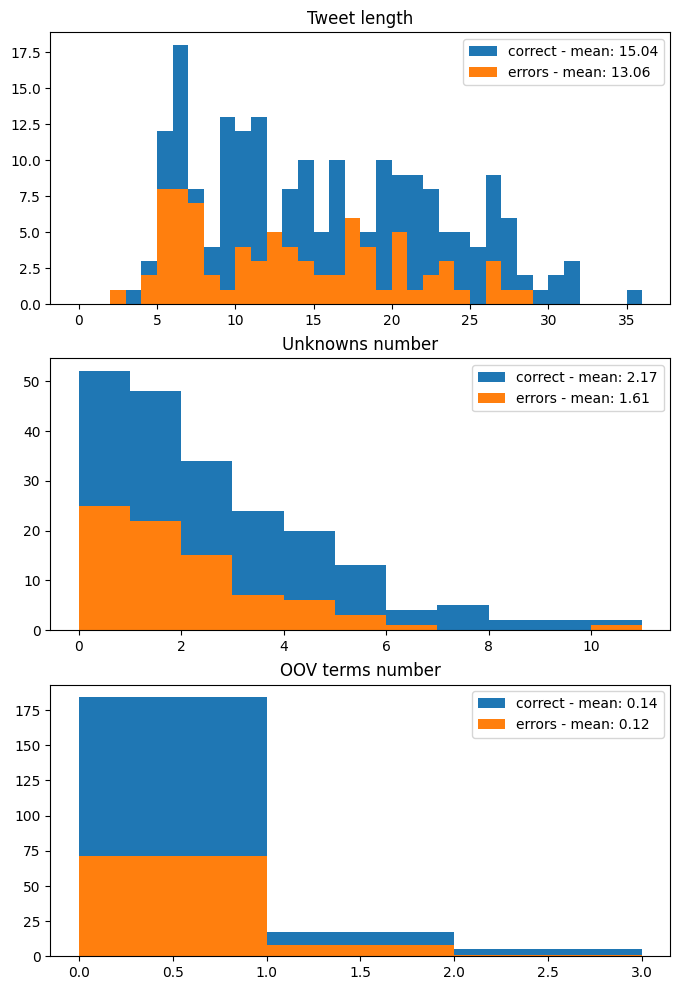

In [41]:
len_correct = df_correct_LSTM.shape[0]
len_errors = df_errors_LSTM.shape[0]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].hist(df_correct_LSTM['tweet_length'], bins=range(max_len), label=f'correct - mean: {np.mean(df_correct_LSTM.tweet_length):.2f}')
axes[0].hist(df_errors_LSTM['tweet_length'], bins=range(max_len), label=f'errors - mean: {np.mean(df_errors_LSTM.tweet_length):.2f}')
axes[0].set_title('Tweet length')
axes[0].legend()

bin_n = max(len(df_correct_LSTM['unknowns_number'].unique()), len(df_errors_LSTM['unknowns_number'].unique()))
axes[1].hist(df_correct_LSTM['unknowns_number'], bins=range(bin_n), label=f'correct - mean: {np.mean(df_correct_LSTM.unknowns_number):.2f}')
axes[1].hist(df_errors_LSTM['unknowns_number'], bins=range(bin_n), label=f'errors - mean: {np.mean(df_errors_LSTM.unknowns_number):.2f}')
axes[1].set_title('Unknowns number')
axes[1].legend()

bin_n = max(len(df_correct_LSTM['oov_terms_number'].unique()), len(df_errors_LSTM['oov_terms_number'].unique()))
axes[2].hist(df_correct_LSTM['oov_terms_number'], bins=range(bin_n), label=f'correct - mean: {np.mean(df_correct_LSTM.oov_terms_number):.2f}')
axes[2].hist(df_errors_LSTM['oov_terms_number'], bins=range(bin_n), label=f'errors - mean: {np.mean(df_errors_LSTM.oov_terms_number):.2f}')
axes[2].set_title('OOV terms number')
axes[2].legend()

fig.show()

What can be inferred for the LSTM are the following statements:

- **The LSTM classifier appears to handle Unknown and OOV Terms relatively well**, as these factors don't drastically affect the model performances in general. On the other side, **the Tweet Lenght seems to play a bigger role in the differentiation of correct and incorrect predictions.**

- Tweets that are classified correctly tend to have slightly longer average lengths (mean: 14.91) compared to incorrectly classified tweets (mean: 13.29). In addition, looking at the distributions, there are more instances of shorter tweets in the error distribution, suggesting that shorter tweets might be harder for the classifier to handle. <br>
One reason might be that **the model relies on contextual information present in longer tweets for correct predictions, in contrast to shorter ones, which may lack sufficient information, leading to errors**.

In [42]:
df_err_transformer = pd.read_csv("df_test_Transformer.csv", index_col="id_EXIST")
df_err_transformer['tweet_length'] = df_err_transformer['tweet'].apply(lambda x: len(word_tokenize(x)))
df_err_transformer["unknowns_number"] = df_err_transformer['tweet'].apply(lambda x: len([word for word in word_tokenize(x) if word not in word_listing]))
df_err_transformer["oov_terms_number"] = df_err_transformer['tweet'].apply(lambda x: len([word for word in word_tokenize(x) if word in oov_terms]))

In [43]:
df_correct_transformer = df_err_transformer[df_err_transformer['hard_labels_task1'] == df_err_transformer['predictions']]
df_errors_transformer = df_err_transformer[df_err_transformer['hard_labels_task1'] != df_err_transformer['predictions']]

In [44]:
df_correct_transformer.describe()

,hard_labels_task1,predictions,tweet_length,unknowns_number,oov_terms_number
count,236.000000,236.000000,236.000000,236.000000,236.000000
mean,0.436441,0.436441,15.050847,2.211864,0.127119
std,0.496998,0.496998,7.187279,2.176672,0.423694
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.000000,0.000000,9.000000,1.000000,0.000000
50%,0.000000,0.000000,14.500000,2.000000,0.000000
75%,1.000000,1.000000,20.250000,3.000000,0.000000
max,1.000000,1.000000,31.000000,11.000000,3.000000


In [45]:
df_errors_transformer.describe()

,hard_labels_task1,predictions,tweet_length,unknowns_number,oov_terms_number
count,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.460000,0.540000,11.840000,1.080000,0.160000
std,0.503457,0.503457,7.554861,1.367852,0.370328
min,0.000000,0.000000,2.000000,0.000000,0.000000
25%,0.000000,0.000000,6.000000,0.000000,0.000000
50%,0.000000,1.000000,9.500000,1.000000,0.000000
75%,1.000000,1.000000,15.750000,2.000000,0.000000
max,1.000000,1.000000,35.000000,6.000000,1.000000


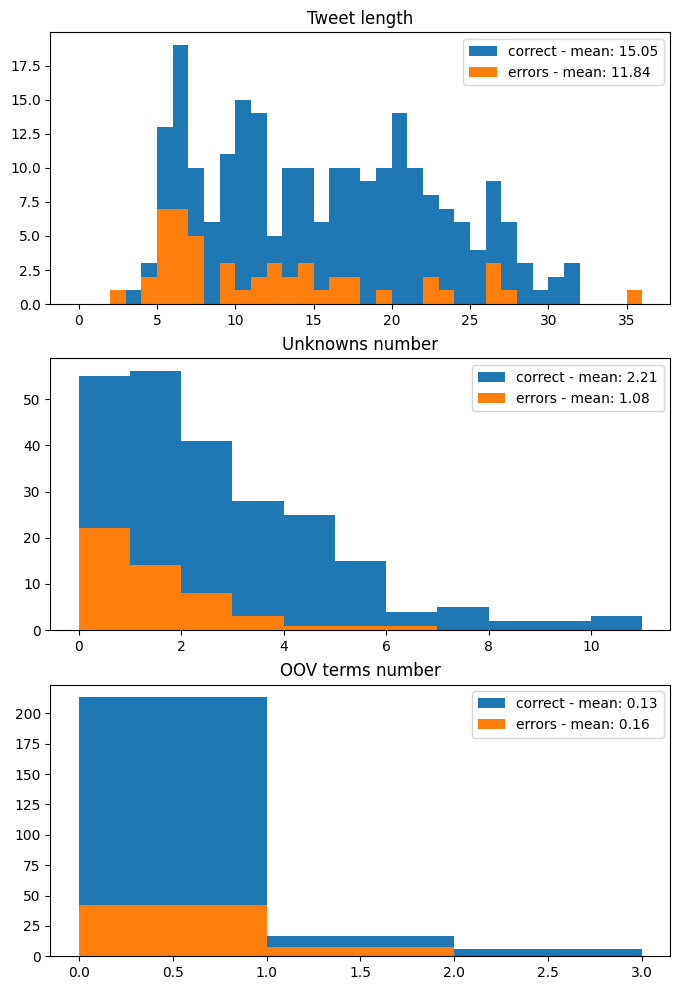

In [46]:
len_correct = df_correct_transformer.shape[0]
len_errors = df_errors_transformer.shape[0]

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
axes[0].hist(df_correct_transformer['tweet_length'], bins=range(max_len), label=f'correct - mean: {np.mean(df_correct_transformer.tweet_length):.2f}')
axes[0].hist(df_errors_transformer['tweet_length'], bins=range(max_len), label=f'errors - mean: {np.mean(df_errors_transformer.tweet_length):.2f}')
axes[0].set_title('Tweet length')
axes[0].legend()

bin_n = max(len(df_correct_transformer['unknowns_number'].unique()), len(df_errors_transformer['unknowns_number'].unique()))
axes[1].hist(df_correct_transformer['unknowns_number'], bins=range(bin_n), label=f'correct - mean: {np.mean(df_correct_transformer.unknowns_number):.2f}')
axes[1].hist(df_errors_transformer['unknowns_number'], bins=range(bin_n), label=f'errors - mean: {np.mean(df_errors_transformer.unknowns_number):.2f}')
axes[1].set_title('Unknowns number')
axes[1].legend()

bin_n = max(len(df_correct_transformer['oov_terms_number'].unique()), len(df_errors_transformer['oov_terms_number'].unique()))
axes[2].hist(df_correct_transformer['oov_terms_number'], bins=range(bin_n), label=f'correct - mean: {np.mean(df_correct_transformer.oov_terms_number):.2f}')
axes[2].hist(df_errors_transformer['oov_terms_number'], bins=range(bin_n), label=f'errors - mean: {np.mean(df_errors_transformer.oov_terms_number):.2f}')
axes[2].set_title('OOV terms number')
axes[2].legend()

fig.show()

The analysis for the Transformer seems to be quite the same of the LSTM, for a model that suffers from the same problem as before on the shorter tweets. However, the performances are generally better, assessing that **the attention mechanism provides better generalisation properties for all the lenghts**, mitigating the previous problem. It can also be noticed by the fact that even if the f1 score for the Transformer with respect to the LSTM on the validation set is just a bit higher, on the test set the RoBERTa architecture shows a considerable improvement.

## Word Frequency Analysis

The aim this section is to provide a specific view of words occurrences in the tweets. In general, **_Word Frequency Analysis_** is about counting how often each word appears in a given collection of text data in order to identify keywords, common themes and anomalies.

In this case, the analysis is conducted by taking into account the most frequent words in the dataset for all the examples predicted as 1 (sexist) and 0 (not sexist). A comparison between the most frequent words in both classes is provided, with a focus on the wrong classified samples, in order to dectect eventual similarities. This has helped to gain more valuable insights on the textual information and structure of the dataset. The objective is to highlight if there is a predominance of words that drives the predictions towards a certain class label, rather than the other.

The same type of analysis has been carried out for both the LSTM and the Transformer, starting with the best performing model, with the following results.

### Transformer

In [47]:
df_err_transformer[df_err_transformer["predictions"] == 1]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
woman,0.040293
like,0.023025
men,0.015699
look,0.013082
get,0.010989
make,0.008896
man,0.008373
say,0.008373
know,0.007849


In [48]:
df_err_transformer[df_err_transformer["predictions"] == 0]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
get,0.007613
like,0.007165
amp,0.006717
people,0.006717
one,0.006270
u,0.004478
time,0.004478
would,0.004478
say,0.004478


In [49]:
df_errors_transformer["tweet"][df_errors_transformer["predictions"] == 1].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
woman,0.025862
men,0.022989
look,0.014368
let,0.011494
amp,0.011494
man,0.011494
womanism,0.008621
penis,0.008621
lady,0.008621


It can be deduced that the words occurrences for the two classes are different. In particular, the words distribution in the tweets classified as not sexist is quite uniform among all the tokens, as shown by the frequencies. On the other hand, for the sexist samples, there is a predominance of some words, which is reflected also in the false positives predictions.

As a consequence, the main deduction of this analysis is that **the Transformer model tends to classify a tweet as sexist whenever it finds words related to genders like "women", "men" or "look", even if they are used in a non-sexist context**.

### LSTM

In [50]:
df_err_LSTM[df_err_LSTM["predictions"] == 1]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
woman,0.032808
like,0.021435
look,0.012686
men,0.010936
get,0.010499
make,0.008749
say,0.008749
amp,0.007874
man,0.006562


In [51]:
df_err_LSTM[df_err_LSTM["predictions"] == 0]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
people,0.008073
get,0.007535
one,0.006997
like,0.005920
go,0.005382
woman,0.005382
u,0.004844
men,0.004306
amp,0.004306


In [52]:
df_errors_LSTM[df_errors_LSTM["predictions"] == 1]["tweet"].str.split().explode().value_counts(normalize=True).head(10)

,proportion
tweet,
woman,0.013123
amp,0.013123
like,0.010499
look,0.009186
get,0.007874
say,0.007874
time,0.007874
use,0.007874
try,0.007874


The same deduction for the Trasformer holds also for the LSTM, with the differnce that in this case the words under analysis are mostly "woman", "like" and "look". One thing to underline in the case of the LSTM is that among the most frequent words of the misclassified samples there are no references to males or men in general. Therefore, it can be said that **the LSTM model shows some kind of bias towards women in classifying sexist tweets**.

## Confusion Matrices
Looking at the ***Confusion Matrices***, we can evaluate the performances of our binary classification models to discriminate positive from negative tweets.
What can be inferred by the data below is:

* **True Negatives**
  * The LSTM seems to have some troubles in classifying correctly negative tweets. Only the 65% of _non-sexist_ tweets is identified, with respect to the 83% of the Transformer model.
* **False Positives**
  * As a consequence, the false postives ratio of the LSTM is much higher than the one found for Transformer model, with 35% over 17%. If we suppose that a human supervisor is integrated in the overall system, this kind of misclassification might not be a so big issue.
* **True Positives**
  * Considering the true positives, the performance of the models are very similar (81% for the LSTM, 82% for the Transformer). Since identifying a _sexist_ text is more important than misclassifying a _non-sexist_ tweet and given the class imbalance shown before, these values are quite encouraging.
* **False Negatives**
  * As already said, the 19% of false negatives for the LSTM and the 18% for the Transformer are quite good performances. However, not identifying a sexist tweet could be a serious problem, showing the need of some ways to manage the issue and reduce this percentage.
  
In general, the Transformer model seems to be more robust to the class imbalance and the implied biases, as the **False Negative** and **False Positive** percentages are more similar one another. On the other hand, given also the analysis of the word frequencies, the LSTM appears to be more affected by that bias. Further considerations can be done by looking a the **_Precision-Recall Curve_**.

[CHECK]

By considering the difference between **False Negative** and **False Positive** and having previously seen the class imbalance in training set, we could infer that this might lead our model to be more inclined to assign a 0 label to a tweet.


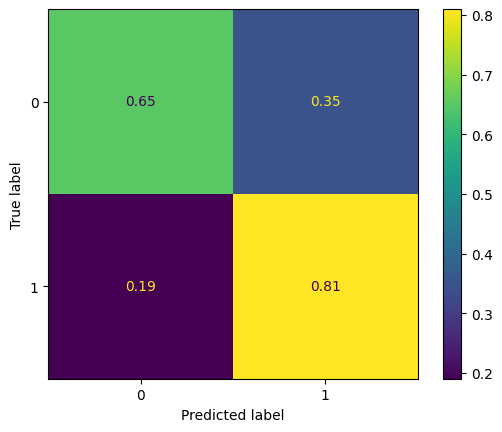

In [53]:
ConfusionMatrixDisplay.from_predictions(df_err_LSTM['hard_labels_task1'].to_list(), df_err_LSTM['predictions'].to_list(), labels=[0,1], normalize="true");

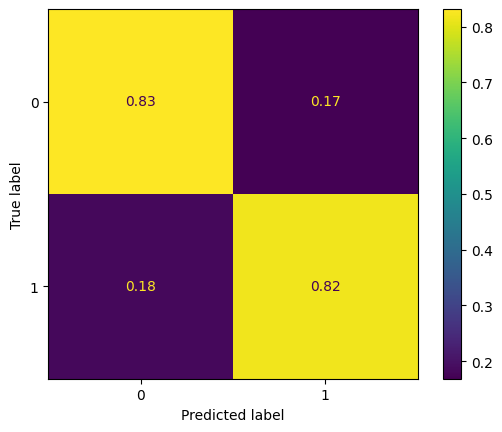

In [54]:
ConfusionMatrixDisplay.from_predictions(df_err_transformer['hard_labels_task1'].to_list(), df_err_transformer['predictions'].to_list(), labels=[0,1], normalize="true");

## Precision-Recall Curves

In order to better understand the performances, strength and witnesses of each model, it is important to analyse the **_Precision-Recall Curves_** of the two models. They provide valuable insights into how the Transformer and LSTM models perform across varying thresholds, especially when balancing **precision** _(accuracy of positive predictions)_ and **recall** _(coverage of true positives)_.

Unlike ***accuracy*** or ***ROC Curves***, the ***Precision-Recall Curves*** avoid overemphasizing true negatives, making them more reliable in scenarios where the positive class is costly to misclassify. Since in our task, misclassifying a _sexist_ tweet as _non-sexist_ one, might be a problem, using this curve is more reasonable.

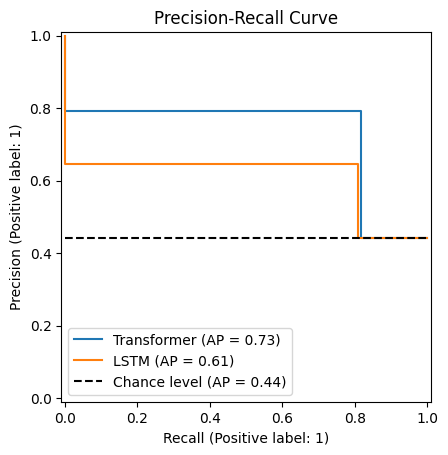

In [76]:
fig, ax = plt.subplots()
PrecisionRecallDisplay.from_predictions(df_err_transformer['hard_labels_task1'], df_err_transformer['predictions'], name="Transformer", ax=ax)
PrecisionRecallDisplay.from_predictions(df_err_LSTM['hard_labels_task1'], df_err_LSTM['predictions'], name="LSTM", ax=ax, plot_chance_level=True)
ax.set_title("Precision-Recall Curve");

### Transformer
The **Transformer** model demonstrates **strong performances with an average precision (AP) of 0.73**, which is higher than the LSTM, as expected. In general, the curve shows that:
- at **_higher thresholds_**, so at _low recall values (left side)_, the Transformer achieves high precision, starting around **0.8**, and maintains this level up to a recall of approximately **0.8**. It means that, for much of the recall range, the Transformer is able to make accurate predictions.
- at **_lower thresholds_**, as recall increases beyond 0.8 _(right side)_, there is a _steady drop in precision_. It means that where the model predicts more positives to increase recall, it also starts to misclassify more negative samples, introducing false positives.

However, **the Transformer's overall ability to maintain high precision at moderate recall levels makes it a strong choice**. In addition, it maintains better precision across thresholds compared to the LSTM, confirming its superior balance between precision and recall.

### LSTM
The **LSTM** model, with an average precision (AP) of **0.61**, shows resonably good performances, with a very similar behaviour with respect to the Transformer. In this case, it can be said that:
- at **_higher tresholds_**, its _precision starts lower_, at around **0.65**, and remains relatively stable up to a recall of **0.8**. However, it is clear that the LSTM consistently **struggles to match the precision-recall balance achieved by the Transformer across all the recall levels**.
- at **_lower tresholds_**, after the recall vaue passes 0.8, the behaviour of the LSTM model is the same as the Transformer, reaching the precision levels of a chance predictor.

In general, even if the the LSTM still performs well in certain regions, **its lower precision suggests that it may be more prone to false positives compared to the Transformer, as confirmed also by the confusion matrix**. This gap highlights areas where the LSTM could be further optimized, for example, by an appropriate treshold tuning.

## Possible Solutions

To address these issues, there could be different solutions. The one presented below consists in managing both the data part and the models:

- regarding data, one effective approach is to **rebalance the training process by applying _class weights_** during the computation of the loss, such to help the model giving equal importance to both classes. <br>
For this purpose, the function `keras.losses.CategoricalFocalCrossentropy()` allows to apply the weights to the LSTM model, while for the Transformer a custom `Trainer` has been designed to use the same type of loss.

- regarding the model, different variants of the previous architectures are proposed. For the LSTM, it has been decided to **increase the number of bidirectional blocks** and add **skip connections** to avoid the vanishing gradient problem. On the other side, a possible improvement for the Transformer is to **fine-tune the pre-trained model by freezing part of the network and updating the remaining weights**.

Other valid alternatives could be:
- **Data Augmentation**, since the dataset size is pretty small, and can be done by gathering new data from other sources or reshuffling the tokenized tweets in actual data, as a pre-processing operation.
- changing the strategy for the creation of the batches by mixing inputs, such to have always a similar number of data for each lenght range (keeping the mean of the tweet lenghts equal for all the batches in ach epoch).

# [Task 8 - 0.5 points] Report



Wrap up your experiment in a short report (up to 2 pages).

### Instructions



* Use the NLP course report template.

* Summarize each task in the report following the provided template.

### Recommendations



The report is not a copy-paste of graphs, tables, and command outputs.



* Summarize classification performance in Table format.

* **Do not** report command outputs or screenshots.

* Report learning curves in Figure format.

* The error analysis section should summarize your findings.


# Submission



* **Submit** your report in PDF format.

* **Submit** your python notebook.

* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...

* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ



Please check this frequently asked questions before contacting us

### Execution Order



You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings



You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture



You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.


### Neural Libraries



You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer



If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation



Each model is trained with at least 3 random seeds.



Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis



To carry out the error analysis you are **free** to either



* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)

* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis



Some topics for discussion include:

   * Precision/Recall curves.

   * Confusion matrices.

   * Specific misclassified samples.

### Bonus Points

Bonus points are arbitrarily assigned based on significant contributions such as:

- Outstanding error analysis

- Masterclass code organization

- Suitable extensions

Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).



**Possible Extensions/Explorations for Bonus Points:**

- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.

- **Experiment with other custom architectures or models from HuggingFace**

- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.












# The End